First, we load the data

In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from scipy import stats
from statsmodels.formula.api import ols
import seaborn
import sklearn


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [9]:
stations = pd.read_csv('station.csv')
trips = pd.read_csv('trip.csv', error_bad_lines=False)

#trips = pd.read_csv("../input/trip.csv")
weathers = pd.read_csv('weather.csv')

#stations.head()

b'Skipping line 50794: expected 12 fields, saw 20\n'


In [10]:
#Function to compute the distance between two point given their latitude and longitude
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [13]:
#Home-made function for the purpose of calculating distance
def calc_dist(stnIDa, stnIDb):
    Alat = 0
    Along = 0
    Blat = 0
    Blong = 0
    distance = 0
    for s in stations.itertuples():
        if s.station_id == stnIDa:
            Alat = s.lat
            Along = s.long
        if s.station_id == stnIDb:
            Blat = s.lat
            Blong = s.long
    if Alat != 0 and Blat != 0 and Along != 0 and Blong != 0:
        distance = abs(haversine(Along, Alat, Blong, Blat))
    return distance

In [14]:
#Compute new columns too trips (takes forever to run)
trips['logduration'] = np.log(trips.tripduration)
trips['age'] = trips.apply(lambda row: datetime.strptime(row['starttime'],'%m/%d/%Y %H:%M').year - row['birthyear'], axis=1)
trips['distance'] = trips.apply(lambda row: calc_dist(row['from_station_id'], row['to_station_id']) , axis=1)

In [16]:
trips['speed'] = np.divide(trips.distance, trips.tripduration / 3600)
trips['startdate'] = trips.apply(lambda row: datetime.strptime(row['starttime'],'%m/%d/%Y %H:%M').strftime('%m/%d/%Y'), axis=1)
#exemple = get_weather_on(trips.startdate)

In [ ]:
#Select rows based on gender
femaletrips = trips.loc[trips['gender'] == 'Female']
maletrips = trips.loc[trips['gender'] == 'Male']
membertrips = trips.loc[trips['usertype'] == 'Member']
nonmembertrips = trips.loc[trips['usertype'] == 'Short-Term Pass Holder']

C:\Users\david\Anaconda3\lib\site-packages\pandas\core\frame.py:5847: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


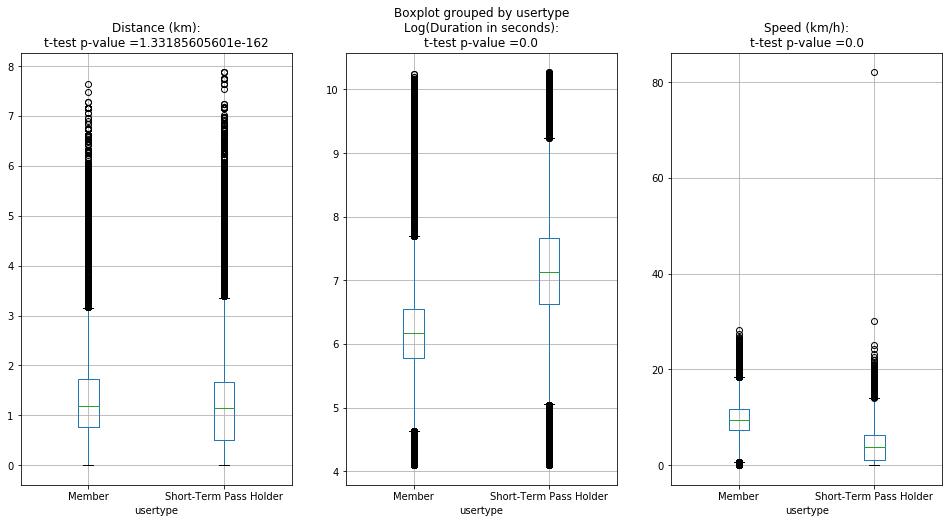

In [99]:
#Create a boxplot
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), sharey=False)
trips.boxplot(['distance', 'logduration', 'speed'], by='usertype', showfliers=True, ax=axes)

dist_ttest = stats.ttest_ind(membertrips.distance, nonmembertrips.distance, equal_var = False).pvalue
logdur_ttest = stats.ttest_ind(membertrips.logduration, nonmembertrips.logduration, equal_var = False).pvalue
speed_ttest = stats.ttest_ind(membertrips.speed, nonmembertrips.speed, equal_var = False).pvalue

axes[0].set_title('Distance (km):\nt-test p-value =' + str(dist_ttest))
axes[1].set_title('Log(Duration in seconds):\nt-test p-value =' + str(logdur_ttest))
axes[2].set_title('Speed (km/h):\nt-test p-value =' + str(speed_ttest))

plt.show()

C:\Users\david\Anaconda3\lib\site-packages\pandas\core\frame.py:5847: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


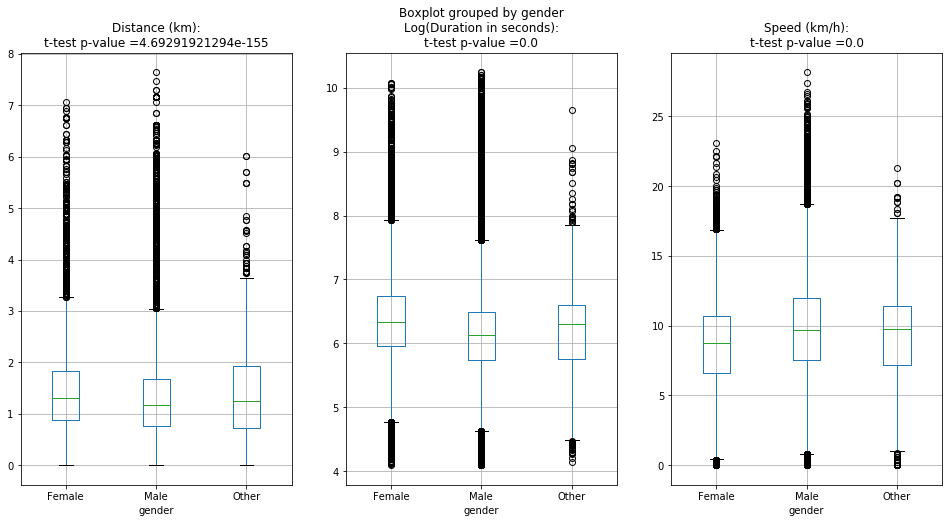

In [68]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), sharey=False)
trips.boxplot(['distance', 'logduration', 'speed'], by='gender', showfliers=True, ax=axes)
dist_ttest = stats.ttest_ind(femaletrips.distance, maletrips.distance, equal_var = False).pvalue
logdur_ttest = stats.ttest_ind(femaletrips.logduration, maletrips.logduration, equal_var = False).pvalue
speed_ttest = stats.ttest_ind(femaletrips.speed, maletrips.speed, equal_var = False).pvalue

axes[0].set_title('Distance (km):\nt-test p-value =' + str(dist_ttest))
axes[1].set_title('Log(Duration in seconds):\nt-test p-value =' + str(logdur_ttest))
axes[2].set_title('Speed (km/h):\nt-test p-value =' + str(speed_ttest))
plt.show()

scipy.stats.stats.Ttest_indResult

In [45]:
def get_precipitations_on(tripdates):
    precipitations = pd.DataFrame()
    cntr = 0
    for date in tripdates:
        weather = weathers.loc[weathers['Date'] == date]
        precipitations = precipitations.append(weather.Precipitation_In)
        cntr += 1
        print(cntr, end="\r")
        
    return precipitations
        

In [20]:
def tripcount_vs_precip_for(selected_trips):
    shape = weathers.shape
    cntr = 0
    nb_of_trips = []
    precipitations = []
    for i in range(0, shape[0]):
        print(i, end="\r")
        sample = selected_trips.loc[selected_trips['startdate'] == weathers.Date[i]]
        nb_of_trips.append(np.sum(sample.tripduration))
        precipitations.append(weathers.Precipitation_In[i])

    return np.column_stack((precipitations, nb_of_trips))

In [21]:
femaletrips = trips.loc[trips['gender'] == 'Female']
maletrips = trips.loc[trips['gender'] == 'Male']
femarray = tripcount_vs_precip_for(femaletrips)
menarray = tripcount_vs_precip_for(maletrips)


In [22]:
print(femarray)

[[  0.00000000e+00   1.00513276e+05]
 [  1.10000000e-01   1.24323104e+05]
 [  4.50000000e-01   7.64894320e+04]
 ..., 
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00]]


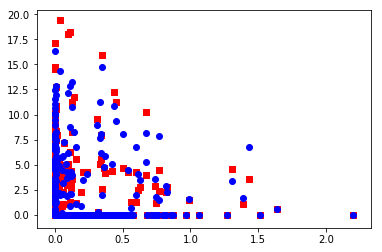

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(femarray[:,0], np.divide(femarray[:,1], np.mean(femarray[:,1])), c = 'r', marker = 's')
ax1.scatter(menarray[:,0], np.divide(menarray[:,1], np.mean(menarray[:,1])), c = 'b')

plt.show()

In [24]:
membertrips = trips.loc[trips['usertype'] == 'Member']
nonmembertrips = trips.loc[trips['usertype'] == 'Short-Term Pass Holder']
membarray = tripcount_vs_precip_for(membertrips)
nonmembarray = tripcount_vs_precip_for(nonmembertrips)

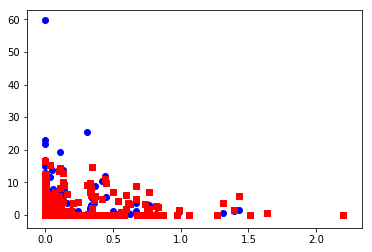

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(nonmembarray[:,0], np.divide(nonmembarray[:,1], np.mean(nonmembarray[:,1])), c = 'b')
ax1.scatter(membarray[:,0], np.divide(membarray[:,1], np.mean(membarray[:,1])), c = 'r', marker = 's')


plt.show()

In [26]:
#Select rows based on gender
femaletrips = trips.loc[trips['gender'] == 'Female']
maletrips = trips.loc[trips['gender'] == 'Male']
membertrips = trips.loc[trips['usertype'] == 'Member']
nonmembertrips = trips.loc[trips['usertype'] == 'Short-Term Pass Holder']

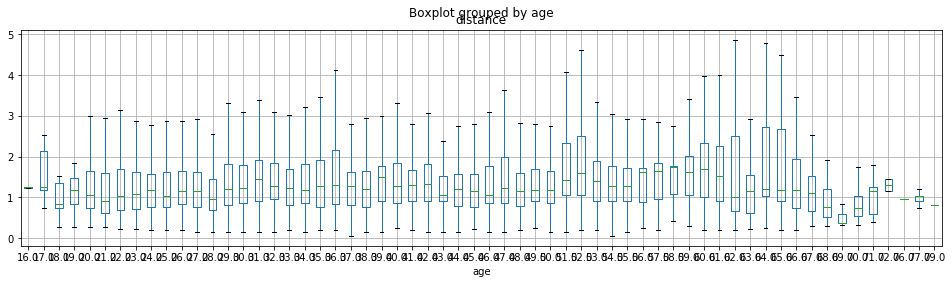

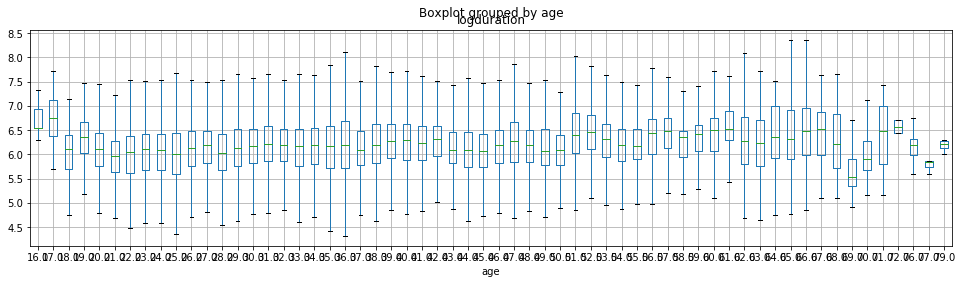

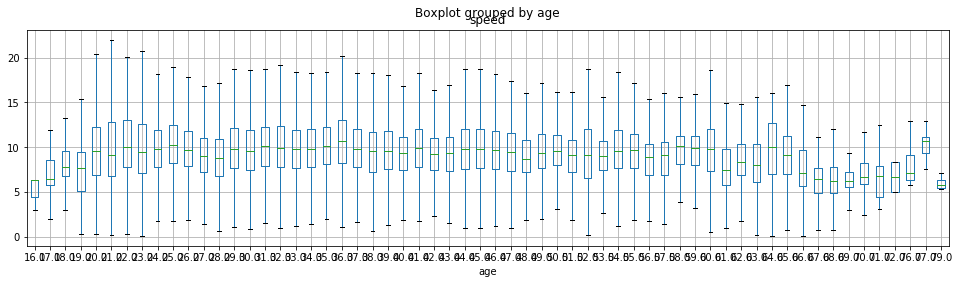

In [87]:
membertrips.loc[trips['distance'] != 0].boxplot(['distance'], by='age',  figsize=(16, 4),  showfliers=False, manage_xticks=True)
membertrips.loc[trips['distance'] != 0].boxplot(['logduration'], by='age',  figsize=(16, 4),  showfliers=False)
membertrips.loc[trips['distance'] != 0].boxplot(['speed'], by='age',  figsize=(16, 4),  showfliers=False)
plt.show()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


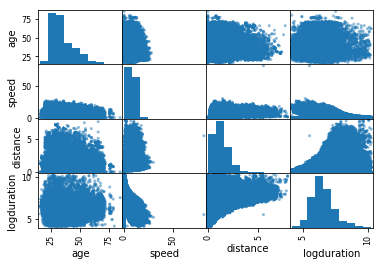

In [29]:
from pandas.tools import plotting
plotting.scatter_matrix(trips[['age', 'speed', 'distance', 'logduration']])
plt.show()

In [72]:
model = ols("speed ~ C(gender)", trips).fit()
print(model.summary())  

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1545.
Date:                Fri, 13 Oct 2017   Prob (F-statistic):               0.00
Time:                        14:09:39   Log-Likelihood:            -4.8783e+05
No. Observations:              181557   AIC:                         9.757e+05
Df Residuals:                  181554   BIC:                         9.757e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.5777      0

In [75]:
seaborn.pairplot(trips, vars=['age', 'speed', 'distance', 'logduration'], kind='reg')  

ValueError: max must be larger than min in range parameter.

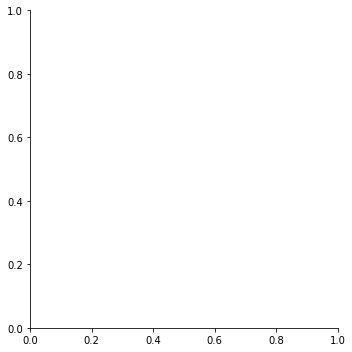

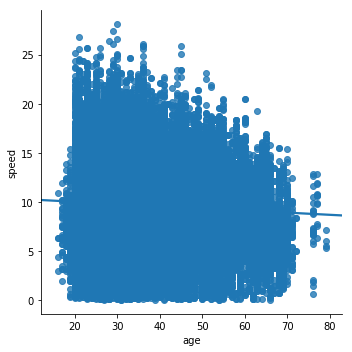

In [95]:
data = trips.loc[trips['distance'] != 0]
seaborn.lmplot(y='speed', x='age', data= data)
plt.show()